In [ ]:
# !pip3 install wordcloud
# !pip3 install polyglot
# !pip3 install pyicu
# !pip3 install pycld2
# !pip3 install morfessor
# !pip3 install polyglot
# !pip3 install fuzzywuzzy

In [467]:
import os
import pandas as pd
import sys
import numpy as np 
import spacy
import nltk
from nltk import word_tokenize, sent_tokenize, RegexpParser, tree
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from fuzzywuzzy import fuzz, process

from tqdm import tqdm_notebook, tqdm
from collections import Counter
import re
import operator
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from ast import literal_eval

import string 

## https://markhneedham.com/blog/2017/11/28/python-polyglot-modulenotfounderror-no-module-named-icu/
from polyglot.detect import Detector

tqdm.pandas()

/Users/felisialoukou/.virtualenvs/corona/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Load in the survey data

In [2]:
DATA_DIR = "../../data"

survey_filename = os.path.join(DATA_DIR, "joined_uis_all_of_march.csv")
df = pd.read_csv(survey_filename)

/Users/felisialoukou/.virtualenvs/corona/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Some row duplication present

In [3]:
print(df.shape, df.intents_clientID.nunique(), df.primary_key.nunique(), df.session_id.nunique())

print(df.columns)

df[df.session_id.isna()].shape

(55198, 58) 24792 35416 43458
Index(['primary_key', 'intents_clientID', 'fullVisitorId', 'visitId',
       'ga_visitNum', 'Started', 'Ended', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6',
       'Q7', 'Q8', 'session_id', 'dayofweek', 'isWeekend', 'hour', 'country',
       'country_grouping', 'UK_region', 'UK_metro_area', 'channelGrouping',
       'deviceCategory', 'total_seconds_in_session_across_days',
       'total_pageviews_in_session_across_days', 'finding_count',
       'updates_and_alerts_count', 'news_count', 'decisions_count',
       'speeches_and_statements_count', 'transactions_count',
       'regulation_count', 'guidance_count', 'business_support_count',
       'policy_count', 'consultations_count', 'research_count',
       'statistics_count', 'transparency_data_count',
       'freedom_of_information_releases_count', 'incidents_count',
       'done_page_flag', 'count_client_error', 'count_server_error',
       'ga_visit_start_timestamp', 'ga_visit_end_timestamp',
       'intents_start

(11042, 58)

In [4]:
df.drop_duplicates("primary_key", inplace = True)
df.reset_index(inplace=True, drop=True)

## Functions for sentence tokenization, part of speech tagging, PII placeholder stripping, ngram computation

In [5]:
nlp = spacy.load("en_core_web_sm")

pii_filtered = ["DATE_OF_BIRTH", "EMAIL_ADDRESS", "PASSPORT", "PERSON_NAME", 
                "PHONE_NUMBER", "STREET_ADDRESS", "UK_NATIONAL_INSURANCE_NUMBER", "UK_PASSPORT"]
pii_regex = "|".join([f"\\[{p}\\]" for p in pii_filtered])
pii_regex

'\\[DATE_OF_BIRTH\\]|\\[EMAIL_ADDRESS\\]|\\[PASSPORT\\]|\\[PERSON_NAME\\]|\\[PHONE_NUMBER\\]|\\[STREET_ADDRESS\\]|\\[UK_NATIONAL_INSURANCE_NUMBER\\]|\\[UK_PASSPORT\\]'

In [6]:
stop_words = list(stopwords.words('english'))
punctuation = list(string.punctuation) + ['’']
token_blacklist = stop_words + punctuation + pii_filtered

def split_sentences(comment):
    return nltk.sent_tokenize(comment)

def remove_stopwords_punctation(sentences):
    return [[(t[0], t[1], t[2]) for t in sent if t[0].lower() not in token_blacklist] for sent in sentences]

def replace_pii_regex(text):
    return re.sub(pii_regex, "", text)

def compute_ngrams(processed_comment, n, stemming=False, filtering=False):
    # processed_comment = part_of_speech_tag(comment)
    if filtering:
        processed_comment = remove_stopwords_punctation(processed_comment)
    index = 2 if stemming else 0
    tokens = [token[index] for sent in processed_comment for token in sent]
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram).lower() for ngram in ngrams]


def part_of_speech_tag(comment):
    sentences = split_sentences(comment)
    return [[(token.text, token.tag_, token.lemma_) for token in nlp(sentence)] for sentence in sentences]

In [7]:
t = "This is a test with punctuation’. this is another sentence."
processed_t = part_of_speech_tag(t)
compute_ngrams(processed_t, 2, stemming=False, filtering=True)

['test punctuation', 'punctuation another', 'another sentence']

## Detect feedback language
There is a bit of foreign language spam in some responses, detect non (primarily) english comments and drop

In [8]:
def detect_language(text):
    if text!="-":
        try:
            langs = {language.confidence:language.code for language in Detector(text, quiet=True).languages}
            return langs[max(langs.keys())]
        except:
            return f"[ERROR] {text}"
    return "-"

In [9]:
df['Q3_pii_removed'] = df['Q3'].progress_map(replace_pii_regex)
df = df[(df.Q3_pii_removed.str.len()<4000)]
df['language'] = df['Q3_pii_removed'].progress_map(detect_language)

  0%|          | 0/35393 [00:00<?, ?it/s]Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the langua

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
 20%|█▉        | 6951/35393 [00:00<00:02, 9789.42it/s]Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
 54%|█████▍    | 19273/35393 [00:01<00:01, 10763.74it/s]Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to de

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

In [10]:
lang_dist = df['language'].value_counts().to_dict()
print(f"Number of unique languages: {len(lang_dist)}")
print(f"English: {round((lang_dist['en']*100)/sum(lang_dist.values()), 2)}%")
print(f"-: {round((lang_dist['-']*100)/sum(lang_dist.values()), 2)}%")
list(lang_dist.items())[0:10]

Number of unique languages: 71
English: 90.98%
-: 7.84%


[('en', 32202),
 ('-', 2775),
 ('un', 62),
 ('xh', 49),
 ('da', 48),
 ('gd', 19),
 ('sco', 13),
 ('it', 12),
 ('mg', 12),
 ('sv', 12)]

In [11]:
df['is_en'] = df['language'].isin(["en", "un", "-", "sco"])

### Part of speech tag
Run this the first time and save, then just load df

In [1525]:
# df['pos_tag'] = df[['Q3_pii_removed', 'is_en']].progress_apply(lambda x: part_of_speech_tag(x[0]) 
#                                                      if x[1] else [], axis=1)
# df['lemmas'] = df['pos_tag'].progress_map(lambda x: [token[2] for sent in x for token in sent])

# df['words'] = df['pos_tag'].progress_map(lambda x: [token[0] for sent in x for token in sent])

# df.to_csv(os.path.join(DATA_DIR, "joined_uis_all_of_march_lang_pos.csv"), index=False)
df = pd.read_csv(os.path.join(DATA_DIR, "joined_uis_all_of_march_lang_pos.csv"))
df['pos_tag'] = df['pos_tag'].map(literal_eval)

/Users/felisialoukou/.virtualenvs/corona/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Extract noun and verb phrases

In [22]:
part_of_speech_tag(df.Q3_pii_removed.iloc[0])[0][0]

('Searching', 'VBG', 'search')

In [787]:
grammar = r"""
    cc:
    {<CC>}
    pronoun:
    {<DT><IN><PRP>}
    {<IN>?<PRP>}
    noun_verb:
    {<IN>?<JJ.*>*<NN.*>+<HYPH>?<VBD|VBN|VBG><NN.*>*}
    verb:
    {<IN>*<VB.*><IN>}
    {<WRB><TO><VB.*>}
    {<TO><VB.*><IN|RP>?<WRB>}
    {<VB.*><TO><VB.*><RB>?<TO>?}
    {<IN><EX><VB.*>}
    {<RB><TO><VB.*>+}
    {<TO>?<VB.*><IN|WDT|WP>}
    {<WP><VB.*>}
    {<VB.*><RB><VB.*>*}
    {<WDT>?<TO>?<MD|VB.*>?<RB>?<TO|IN>?<V.*>+<CC>?<V.*>*<IN|RP>?<IN>?}
    {<MD><RB>*<VB.*>*}
    {<VB.*><IN|TO><IN>?}
    {<TO><VB.*><IN>+}
    prep_noun:
    {<IN><NN.*><HYPH>?<NN.*>*}
    {<IN>+<PRP\$>?<NN><CD>?}
    {<IN><CD><.*>}
    {<RP>?<IN>+<JJ.*>*<NN.*>+}
    {<IN><DT><NN.*><JJ.*>*<NN><HYPH>?<NN>}
    {<IN><NN.*>(<HYPH>?<NN.*>)?}
    {<JJ.*>*<IN><DT>?<NN.*>+<CD>?<NN.*>?}
    {<IN>+<DT>*<JJ>?<CD>?<NN.*>+<CD>?<NN.*>?}
    noun:
    {<CD><NN.*>}
    {<DT><NN.*>}
    {<JJ.*><NN.*>*<CD>}
    {<NN.*><CD><JJ.*>?}
    {<JJ.*|NN.*><IN|TO><PRP>}
    {<CD><NN.*><JJ.*>}
    {<WRB><RB><JJ.*>*<NN.*>*}
    {<DT><JJ.*>*<NN.*>+}
    {<NN.*><CD>?<JJ.*>*<NN.*>*}
    {<IN>+<CD>*<POS>*<IN>*<NN.*>}
    {<IN><PRP\$>?<JJ.*>*<NN.*>}
    {<NN.*><HYPH><NN.*>}
    {<DT>?<CD>?<JJ.*>?<CC>?<JJ.*>?<NN.*>+}
    {<NN.*><HYPH>?<NN.*|JJ.*|VB.*>*}
    {(<NN|NNS>|<NNP|NNPS>)<NNP|NN|NNS|NNPS>+}
    {(<NN|NNS>+|<NNP|NNPS>+)<IN|CC>(<PRP\$|DT><NN|NNS>+|<NNP|NNPS>+)}
    {<JJ|RB|CD>*<NNP|NN|NNS|NNPS>+}
    {<NNP|NN|NNS|NNPS>+}
    adjective:
    {<RB>*<JJ.*><CD>?}
    """

class Chunk:

    def __init__(self, label, tokens, indices):
        self.label = label
        self.tokens = tokens
        self.indices = indices
        self.text = self.text()
        self.lemma = self.lemma()
        self.important_lemma = self.important_lemma()
        self.important_word = self.important_word()

    def text(self):
        return " ".join([w for w,  _ , _  in self.tokens])
    
    def lemma(self):
        return " ".join([l for _,  _ , l  in self.tokens])
    
    def tagable_words(self):
        return [(w, pos) for w,  pos , _  in self.tokens if re.search(r"(NN)|(VB)", pos)]
    
    def important_word(self):
        return " ".join([w for w,  pos , _  in self.tokens if re.search(r"(NN)|(VB)|(JJ)|(CD)", pos) ])
    
    def important_lemma(self):
        return " ".join([l for _,  pos , l  in self.tokens if re.search(r"(NN)|(VB)|(JJ)|(CD)", pos) ])
    
parser = RegexpParser(grammar)

def chunk_text(tagged):
    chunks = parser.parse(tagged)
    index = 0
    segments = []
    for el in chunks:
        if type(el) == tree.Tree:
            chunk = Chunk(el.label(), el.leaves(), list(range(index, index + len(el.leaves()))))
            segments.append(chunk)
            index += len(el.leaves())
        else:
            index += 1
    return segments

def extract_phrase(sentences, merge_inplace=False):
    chunks = []
    for sentence in sentences:
        chunks.append(chunk_text(sentence))
    if merge_inplace:
        return [merge_adjacent_chunks(chunk) for chunk in chunks]
    return chunks  

def merge_adjacent_chunks(chunks):
    merged = []
    previous_label = ""
    for chunk in chunks:
        if chunk.label == previous_label and chunk.label != "prep_noun":
            merged[-1] = Chunk(chunk.label, 
                               merged[-1].tokens + chunk.tokens, 
                               merged[-1].indices + chunk.indices)
        else:
            merged.append(chunk)
        previous_label = chunk.label
    return merged

def compute_combinations(sentences, n):
    return [chunks[i:i+n] for chunks in sentences for i in range(len(chunks)-(n-1))]
  

In [788]:
def extract_wordnet_cats(chunk):
    return [(word, tag, wordnet_category(word, tag)) for  word,tag in chunk.tagable_words()]

In [952]:
example = df.iloc[7]
example = df[df.Q3.str.contains("have no symptoms")].iloc[1]
print(regex_for_theme(example.Q3))

print(example.Q3)
print()
print(example.pos_tag)
print()
for sent in extract_phrase(example.pos_tag, True):
    for chunk in sent:
        print("{0:10} {1:20} {2} {3}".format(chunk.label.upper(), chunk.text, chunk.indices, 
                                             extract_wordnet_cats(chunk)))
    print()
    for combo in compute_combinations([sent], 2):
        print(f"{combo[0].text}, {combo[1].text}")
        
#     for combo in compute_combinations([sent], 3):
#         print(f"{combo[0].text}, {combo[1].text}, {combo[2].text}")
    print("=====")

support
With the current lock down I have told them that I will not be going into the office as my wife has been given the means to work from home my kids are both home school and college closed work have decided they are an essential business (sell valves pumps actuators) so because I have no symptoms nor do my family they expect me in and because I'm not they've said I will not be entitled paying or claim anything!? 

[[('With', 'IN', 'with'), ('the', 'DT', 'the'), ('current', 'JJ', 'current'), ('lock', 'NN', 'lock'), ('down', 'RB', 'down'), ('I', 'PRP', '-PRON-'), ('have', 'VBP', 'have'), ('told', 'VBD', 'tell'), ('them', 'PRP', '-PRON-'), ('that', 'IN', 'that'), ('I', 'PRP', '-PRON-'), ('will', 'MD', 'will'), ('not', 'RB', 'not'), ('be', 'VB', 'be'), ('going', 'VBG', 'go'), ('into', 'IN', 'into'), ('the', 'DT', 'the'), ('office', 'NN', 'office'), ('as', 'IN', 'as'), ('my', 'PRP$', '-PRON-'), ('wife', 'NN', 'wife'), ('has', 'VBZ', 'have'), ('been', 'VBN', 'be'), ('given', 'VBN', 'gi

## Compute linguistic pattern combinations

In [790]:
def compute_wordnet_tags_per_chunk(sentences, wordnet_tags):
     for sent in sentences:
        for chunk in sent:
            tagged_words = extract_wordnet_cats(chunk)
            for word,pos,wordnet_tag in tagged_words:
                if wordnet_tag not in wordnet_tags.keys():
                    wordnet_tags[wordnet_tag] = Counter()
                wordnet_tags[wordnet_tag][word.lower()] +=1

def compute_linguistic_patterns(df_series, n):
    pattern_dictionary = {}
    wordnet_tags = {}

    for vals in tqdm_notebook(df_series.values):
        sents = extract_phrase(vals, True)
        compute_wordnet_tags_per_chunk(sents, wordnet_tags)
                            
        for combo in compute_combinations(sents, n):
            key = tuple([c.label for c in combo])
            counter_key =  tuple([c.text.lower() for c in combo])
            
            if key not in pattern_dictionary.keys():
                pattern_dictionary[key]=Counter()

            pattern_dictionary[key][counter_key]+=1
                        
    return pattern_dictionary, wordnet_tags

## ELMO embeddings/clustering

In [791]:
# from allennlp.commands.elmo import ElmoEmbedder
# from sklearn.cluster import KMeans

# allennlp_models = "https://allennlp.s3.amazonaws.com/models/elmo/"
# options_file = allennlp_models + "2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
# weight_file = allennlp_models + "2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"
# elmo = ElmoEmbedder(options_file, weight_file)

# def embed(sentences):
#     tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]
#     word_embeddings = elmo.embed_sentences(tokenized_sentences, batch_size=16)
#     return [np.mean(embedding, axis=1)[-1] for embedding in
#             tqdm(word_embeddings, total=len(tokenized_sentences))]

# class Clusterer:
#     def __init__(self, cluster_num):
#         self.model = KMeans(n_clusters=cluster_num)

#     def fit(self, embeddings):
#         self.model.fit(embeddings)

#     def transform(self, embeddings):
#         return self.model.transform(embeddings)

#     def map_sentences_to_clusters(self, texts):
#         clusters = {}
#         for text, assignment in zip(texts, self.model.labels_):
#             if assignment in clusters.keys():
#                 clusters[assignment].append(text)
#             else:
#                 clusters[assignment] = [text]

#         return clusters

In [792]:
# phrase_dict = {' '.join(phrases):count for phrases,count in pattern_d[("verb", "noun")].items()}
# phrases  = list(phrase_dict.keys())
# embeddings = embed(phrases)
# np.save(os.path.join(DATA_DIR, "elmo_embeddings.npy"), dict(zip(phrases, embeddings)))

In [793]:
# kmeans = Clusterer(10)
# kmeans.fit(embeddings)
# chusters = kmeans.map_sentences_to_clusters(phrases)
# for k,v in chusters.items():
#     print(k)
#     print(v[0:15])
#     print()

## Wordnet categorization of individual arguments

In [794]:
def get_wordnet_pos(pos):
    if pos.startswith("NN"):
        return wn.NOUN
    if pos.startswith("VB"):
        return wn.VERB
    if pos.startswith("RB"):
        return wn.ADV
    if pos.startswith("JJ"):
        return wn.ADJ
    
def wordnet_category(word, pos):
    wn_pos = get_wordnet_pos(pos)
    if re.search("[cCo]((rona)|(vid))", word):
        return "noun.state"
    if len(word.split(" ")) > 1:
        word = word.split(" ")[-1]
    if len(wn.synsets(word, wn_pos))>0 :
        syns = wn.synsets(word, wn_pos)
#         [syn.lexname() for syn in syns]
        return syns[0].lexname()
    return "?"

def bulk_compute_categories(argument_list):
    counter = Counter()
    for argument, counts in argument_list.items():
        wordnet_cat = wordnet_category(argument, "NN")
        if "Tops" in wordnet_cat:
            wordnet_cat = f"noun.{argument.lower().split(' ')[-1]}"
        counter[wordnet_cat] += counts
    return counter

In [795]:
def wordnet_categories(word, pos):
    wn_pos = get_wordnet_pos(pos)
    if re.search("[cCo]((rona)|(vid))", word):
        return "noun.state"
    if len(word.split(" ")) > 1:
        word = word.split(" ")[-1]
    if len(wn.synsets(word, wn_pos))>0 :
        syns = wn.synsets(word, wn_pos)
#         [syn.lexname() for syn in syns]
        return [syn.lexname() for syn in syns]
    return "?"

## Inspect arg1-arg2 grammatical patterns

In [796]:
pattern_d, wordnet_tags = compute_linguistic_patterns(df.pos_tag, 2)
pattern_d.keys(), len(pattern_d)

/Users/felisialoukou/.virtualenvs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


(dict_keys([('verb', 'noun'), ('noun', 'prep_noun'), ('prep_noun', 'prep_noun'), ('noun', 'verb'), ('verb', 'pronoun'), ('pronoun', 'verb'), ('noun', 'adjective'), ('adjective', 'noun'), ('verb', 'noun_verb'), ('noun_verb', 'verb'), ('pronoun', 'prep_noun'), ('prep_noun', 'cc'), ('prep_noun', 'noun_verb'), ('noun_verb', 'pronoun'), ('verb', 'adjective'), ('noun', 'cc'), ('cc', 'pronoun'), ('noun', 'pronoun'), ('cc', 'verb'), ('prep_noun', 'verb'), ('verb', 'cc'), ('noun_verb', 'prep_noun'), ('prep_noun', 'noun'), ('noun', 'noun_verb'), ('verb', 'prep_noun'), ('prep_noun', 'pronoun'), ('cc', 'noun'), ('adjective', 'prep_noun'), ('noun_verb', 'adjective'), ('adjective', 'verb'), ('adjective', 'cc'), ('cc', 'adjective'), ('adjective', 'pronoun'), ('prep_noun', 'adjective'), ('noun_verb', 'noun'), ('cc', 'prep_noun'), ('pronoun', 'adjective'), ('noun_verb', 'cc'), ('cc', 'noun_verb'), ('pronoun', 'noun'), ('pronoun', 'cc'), ('pronoun', 'noun_verb'), ('adjective', 'noun_verb')]),
 43)

In [797]:
for key,value in sorted(wordnet_tags.items(), 
                        key = lambda x: sum(x[1].values()), 
                        reverse=True):
    print(key, sum(value.values()))
    for i,(k,v) in enumerate(value.most_common(20),1):
        print(f"{i}. {k}: {v}")
    print()

verb.stative 43135
1. is: 9419
2. am: 5847
3. are: 5562
4. be: 4611
5. was: 3671
6. been: 2835
7. need: 2680
8. being: 1454
9. live: 863
10. were: 578
11. keep: 499
12. needed: 433
13. living: 333
14. needs: 285
15. continue: 260
16. required: 180
17. lives: 171
18. underlying: 169
19. qualify: 165
20. waiting: 151

verb.possession 35297
1. have: 9756
2. find: 6293
3. get: 5021
4. has: 2905
5. had: 1593
6. pay: 1073
7. received: 771
8. paid: 683
9. getting: 602
10. having: 557
11. got: 556
12. given: 356
13. give: 337
14. receive: 335
15. lost: 233
16. access: 232
17. paying: 203
18. obtain: 168
19. seek: 158
20. shop: 146

noun.communication 28428
1. information: 3529
2. advice: 2654
3. guidance: 953
4. website: 832
5. credit: 818
6. list: 780
7. info: 736
8. letter: 697
9. email: 674
10. mot: 626
11. address: 611
12. form: 592
13. details: 535
14. text: 532
15. message: 491
16. page: 397
17. claim: 361
18. account: 348
19. visa: 334
20. update: 324

? 24969
1. 'm: 1265
2. ’m: 968
3. 

In [798]:
# for i, (k,v) in enumerate(sorted(pattern_d.items(), 
#                                  key = lambda x: sum(x[1].values()), 
#                                  reverse=True), 
#                           1):
#     print(f"{i}. {k}: {sum(v.values())}")

In [799]:
for i, (k,v) in enumerate(sorted(pattern_d.items(), 
                                 key = lambda x: len(x[1]), 
                                 reverse=True), 
                          1):
    print(f"{i}. {' - '.join([ks.upper() for ks in k])} : {len(v)}\n-------------")
    for j, (kk,vv) in enumerate(pattern_d[k].most_common(50), 1):
        print(f"{j}. \'{' '.join([f'[{kks}]' for kks in kk])}\' : {vv}")
    print()
    print("=======\n")

1. VERB - NOUN : 50347
-------------
1. '[stay at] [home]' : 192
2. '[need] [help]' : 167
3. '[looking for] [information]' : 130
4. '[go to] [work]' : 116
5. '[to find] [information]' : 111
6. '[have] [copd]' : 104
7. '[looking for] [advice]' : 78
8. '[work from] [home]' : 69
9. '[to get] [information]' : 68
10. '[have] [no income]' : 61
11. '[to renew] [driving licence]' : 60
12. '[have] [asthma]' : 58
13. '[renew driving] [licence]' : 57
14. '[to get] [help]' : 51
15. '[to get] [advice]' : 51
16. '[register as] [a vulnerable person]' : 50
17. '[isolate for] [12 weeks]' : 48
18. '[was looking for] [information]' : 46
19. '[is] [no information]' : 45
20. '[am] [a key worker]' : 43
21. '[to find] [advice]' : 43
22. '[to find out] [information]' : 43
23. '[can not work from] [home]' : 43
24. '[looking for] [help]' : 42
25. '[looking for] [guidance]' : 40
26. '[need] [advice]' : 40
27. '[is] [nothing]' : 39
28. '[to change] [address]' : 35
29. '[get] [help]' : 34
30. '[can get] [help]' : 

1. '[copd] [and]' : 110
2. '[work] [and]' : 106
3. '[asthma] [and]' : 89
4. '[husband] [and]' : 79
5. '[work] [or]' : 74
6. '[home] [and]' : 73
7. '[wife] [and]' : 72
8. '[food] [and]' : 59
9. '[help] [and]' : 52
10. '[information] [and]' : 49
11. '[risk] [and]' : 44
12. '[coronavirus] [and]' : 44
13. '[home] [but]' : 40
14. '[work] [but]' : 39
15. '[advice] [and]' : 35
16. '[the virus] [and]' : 35
17. '[health] [and]' : 34
18. '[rent] [and]' : 33
19. '[tax] [and]' : 31
20. '[people] [and]' : 29
21. '[diabetes] [and]' : 28
22. '[health issues] [and]' : 26
23. '[cancer] [and]' : 26
24. '[workers] [and]' : 26
25. '[family] [and]' : 25
26. '[bills] [and]' : 24
27. '[staff] [and]' : 24
28. '[credit] [but]' : 22
29. '[home] [or]' : 22
30. '[a key worker] [and]' : 22
31. '[children] [and]' : 21
32. '[daughter] [and]' : 21
33. '[pay] [and]' : 21
34. '[partner] [and]' : 21
35. '[symptoms] [and]' : 19
36. '[no income] [and]' : 19
37. '[risk] [but]' : 19
38. '[shopping] [and]' : 18
39. '[car] [a

27. '[and] [sick]' : 8
28. '[and] [asthmatic]' : 8
29. '[and] [easy]' : 8
30. '[or] [essential]' : 8
31. '[and] [able]' : 8
32. '[and] [not sure]' : 8
33. '[and] [national]' : 8
34. '[or] [least]' : 7
35. '[and] [immune]' : 7
36. '[and] [such]' : 7
37. '[and] [local]' : 7
38. '[or] [key]' : 7
39. '[and] [specific]' : 7
40. '[and] [public]' : 7
41. '[and] [much]' : 7
42. '[and] [extremely vulnerable]' : 7
43. '[or] [financial]' : 6
44. '[and] [old]' : 6
45. '[and] [accurate]' : 6
46. '[but] [not extremely vulnerable]' : 6
47. '[and] [confusing]' : 6
48. '[and] [vunerable]' : 6
49. '[or] [high]' : 6
50. '[and] [healthy]' : 6


33. CC - PREP_NOUN : 916
-------------
1. '[and] [from work]' : 31
2. '[and] [at risk]' : 16
3. '[and] [of work]' : 7
4. '[and] [on medication]' : 6
5. '[and] [in isolation]' : 5
6. '[and] [at high risk]' : 5
7. '[and] [at the moment]' : 4
8. '[and] [over 70s]' : 4
9. '[and] [of course]' : 4
10. '[and] [in my opinion]' : 3
11. '[but] [without any symptoms]' : 3
12.

In [929]:
patterns_of_interest = [('verb', 'noun'),
('noun', 'prep_noun'),
('prep_noun', 'prep_noun'),
('verb', 'noun_verb'),
('verb', 'prep_noun'),
('noun', 'noun_verb'),
('noun_verb', 'prep_noun')
]

In [930]:
counter = 0
for i, (k,v) in enumerate(sorted(pattern_d.items(), 
                                 key = lambda x: len(x[1]), 
                                 reverse=True), 
                          1):
    if k in patterns_of_interest:
#         print(f"{i}. {' - '.join([ks.upper() for ks in k])} : {len(v)}\n-------------")
        for j, (kk,vv) in enumerate(pattern_d[k].most_common(), 1):
            if regex_for_theme(" ".join(kk)) == "no-income":
#                 print(regex_for_theme(" ".join(kk)))
#                 print(f"{j}. \'{' '.join([f'[{kks}]' for kks in kk])}\' : {vv}")
                counter+=vv
#         print()
#         print("=======\n")
counter

363

In [931]:
df[(df.Q3.str.contains("self employ")) | (df.Q3.str.contains("self-employ"))].shape

(1413, 64)

## Compute `arg1` - `arg2` co-occurrence db - couples

In [932]:
pattern_db = {}

for vals in tqdm_notebook(df.pos_tag.values):
    sents = extract_phrase(vals, True)
    for combo in compute_combinations(sents, 2):
        key = (combo[0].label, combo[1].label)
        arg1 = combo[0].text.lower()
        arg2 = combo[1].text.lower()
#         arg2 = " ".join([w.lower() for w,_ in combo[1].tagable_words()])
        
        if key not in pattern_db.keys():
            pattern_db[key] = {}
        if arg1 not in pattern_db[key].keys():
            pattern_db[key][arg1] = Counter()
            
        pattern_db[key][arg1][arg2]+=1

print(f"There are {len(pattern_db)} possible grammatical combos.")
for i, (k,v) in enumerate(sorted(pattern_db.items(),
                         key = lambda x: len(x[1].values()),
                         reverse= True)[0:15],
                                 1):
    print(k, len(v))

/Users/felisialoukou/.virtualenvs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until



There are 43 possible grammatical combos.
('verb', 'noun') 22145
('noun', 'verb') 9654
('noun', 'prep_noun') 8571
('verb', 'pronoun') 6655
('noun', 'cc') 5926
('verb', 'adjective') 5919
('prep_noun', 'verb') 5595
('prep_noun', 'prep_noun') 5159
('noun', 'pronoun') 4395
('prep_noun', 'cc') 3928
('prep_noun', 'pronoun') 2947
('verb', 'cc') 2720
('verb', 'prep_noun') 2711
('prep_noun', 'noun') 2559
('adjective', 'noun') 2342


## Find specific mentions

In [1584]:
def regex_for_theme(text):
    if re.search(r"self\s?(-|\s)\s?employ", text.lower()):
        return "self-employ"
    if re.search(r"(deliver(y|(ies)|(ed)))|(slot)|(online shopping)", text.lower()):
        return "delivery"
    if re.search(r"vulnerable", text.lower()):
        return "vulnerable"
    if re.search(r"disab((led)|(ility))", text.lower()):
        return "disabled"
    if re.search(r"no symptom", text.lower()):
        return "no-symptoms"
    if re.search(r"((corona)?(virus))|(covid)", text.lower()):
        return "covid-mention"
    if re.search(r"""((health)|(heart) (problem)|(issue)|(condition)|(attack)|(disease)|(failure))|( ms)|"""+
                 """(copd)|(asthma)|((type)\s?[12])|(diabet)|"""+
                 """(cancer)|(dementia)|(stroke)|(illness)|(a type$)|(cough)|(leukaemia)""", text.lower()):
        return "health-problem"
    if re.search(r"symptom", text.lower()):
        return "symptoms"
    if re.search(r"((at)?(\s(very\s)?high)?\srisk)|(risk list)", text.lower()):
        return "at-risk"
    if re.search(r"""((((a|'|’)m( (in|at)( my)?)?)|aged) (over(-|\s))?"""+
                 """(([789][0-9]($|s|\s))|(old)|(elderly)))|((over(-|\s))?[789][0-9] y)""", text.lower()):
        return "elderly"
    if re.search(r"(carer)|(care home)", text.lower()):
        return "carer"
    if re.search(r"(key\s?(\s|-)?\s?worker)|(nurse($|\s))|(essential worker)", text.lower()):
        return "key-worker"
    if re.search(r"can\s?(no|'|’)?t work", text.lower()):
        return "cannot-work"
    if re.search(r"no ((work)|(income)|(money)|(wage)|(salar))", text.lower()):
        return "no-income"
    if re.search(r"(furlough)|(fired)|(80 %)", text.lower()):
        return "laid-off"
    if re.search(r"""(((can\s?(no|'|’)?t (get|buy|(shop for)))|"""+
                 """((do not)?ha(ve|d) )(no|any|(not enough))?) (food|groceries))""", 
                 text.lower()):
        return "cannot-get-food"
    if re.search(r"can\s?(no|'|’)?t get ((med)|(prescription))", text.lower()):
        return "cannot-get-med"
    if re.search(r"(^med)|(prescription)", text.lower()):
        return "get-med"
    if re.search(r"(travel(\s(advi[sc]e)|(status))?)|(flight)|(destination)", text.lower()):
        return "travel"
    if re.search(r"""(no\s)(\w*\s)?((info)|(clarification)|(advi[sc]e)|((contact )?((details)|(number)))|"""+
                 """(answer)|(update)|(clarity)|(guid(e|(ance)))|(list)|(definition)|"""+
                 """(address)|(link)|(form)|(contact)|(mention))"""
                 , text.lower()):
        return "no-information"
    if re.search(r"""(info)|(clarification)|(advi[sc]e)|((contact )?((details)|(number)))|"""+
                 """(answer)|(update)|(clarity)|(guid(e|(ance)))|(list)|(definition)|"""+
                 """(address)|(link)|(form)|(contact)"""
                 , text.lower()):
        return "information"
    if re.search(r"""(no)\s((letter)|(t(e)?xt)|(message)|(e(\s|(\s?-\s?))?mail)|"""+
                 """(alert)|(notice)|(communication))""", text.lower()):
        return "no-correspondence"
    if re.search(r"(letter)|(t(e)?xt)|(message)|(e(\s|(\s?-\s?))?mail)|(alert)|(notice)", text.lower()):
        return "correspondence"
    if re.search(r"(no\s?((family)|(one)))|(nothing)|(nobody)", text.lower()):
        return "no-one"
    if re.search(r"no ((support)|(aid)|(help)|(assistance)|(access)|(priority))", text.lower()):
        return "no-support"
    if re.search(r"(support)|(aid)|(help)|(assistance)|(access)|(priority)", text.lower()):
        return "support"
    if re.search(r"(child)|((^|\s)son)|(daughter)", text.lower()):
        return "child"
    if re.search(r"""(parent)|(husband)|(wife)|(partner)|"""+
                 """((mo|fa)ther)|(famil(y|(ies)))|(m[uo]m)|(dad)""", text.lower()):
        return "family"
    if re.search(r"(rule)|(restriction)|(measure)|(rights)", text.lower()):
        return "rules"
    if re.search(r"((no)|(a(ny)?)) ((way)|(option)|(choice)|(means)|(idea))", text.lower()):
        return "uncertainty"
    if re.search(r"work ((for)|(in)|(at)|(on))", text.lower()):
        return "work"
    if re.search(r"((self\s|-)?isolat((ion)|(e)|(ing)))|(lock\s?(\s|-)?\s?down)", text.lower()):
        return "self-isolation"
    if re.search(r"(driv(ing|ers)\s)?licen[sc]e", text.lower()):
        return "license"
    if re.search(r"passport", text.lower()):
        return "passport"
    if re.search(r"pension", text.lower()):
        return "pension"
    if re.search(r"(^|\s)h((ome)|(ouse))", text.lower()):
        return "home-mention"
    if re.search(r"(employ)|(work)|(job)|(business)|(company)", text.lower()):
        return "work-mention"
    if re.search(r"(benefit)|(universal credit)|(eligible)|(esa)|(ssp)|(pip)|(allowance)", text.lower()):
        return "benefit"
    if re.search(r"(school)|(student)", text.lower()):
        return "school"
    if re.search(r"(food)|(supplies)|(shopping)|(groceries)", text.lower()):
        return "goods"
    if re.search(r"(money)|(grant)|(fund)|(relief)", text.lower()):
        return "given-money"
    if re.search(r"(bill)|(tax)|(mortgage)|(rent)|(loan)|(debt)|(fine)|(fee)|(insurance)", text.lower()):
        return "bills-to-pay"
    if re.search(r"scheme", text.lower()):
        return "scheme"
    if re.search(r"(^|\s)visa($|\s)", text.lower()):
        return "visa"
    if re.search(r"(data)|(cases)|(situation)|(stat(istic)?s?$)|(status)|(news)|(progress)", text.lower()):
        return "data"
    if re.search(r"dea((th)|d)", text.lower()):
        return "death"
    return "unknown"


In [1585]:
regex_for_theme("stats")

'data'

In [1586]:
def regex_group_verbs(verb):
    if re.search(r"""(f(i|(ou))nd)|(look)|(search)|(clarify)|(ask)|(read)|([ei]nquire)|"""+
                 """(obtain)|(seek)|(know)|((^|\s)see($|\s))|(understand)""", verb):
        return "find-smthg"
    if re.search(r"(access)|(check)|(complete)|(cancel)|(book)|(confirm)", verb):
        return "access-smthg"
    if re.search(r"(get)|(take)|(claim)|(receive)|(sent)|(collect)", verb):
        return "acquire-smthg"
    if re.search(r"(renew)|(change)|(update)|(inform$)|(notify)", verb):
        return "change-smthg"
    if re.search(r"(appl(y|(ied)))|(register)|(qualify)", verb):
        return "apply-smthg"
    if re.search(r"pa(y|(id)|(yed))", verb):
        return "pay-smthg"
    if re.search(r"(contact)|(report)", verb):
        return "contact-smthg"
    if re.search(r"(work)|(employ)", verb):
        return "work-smwhr"
    if re.search(r"(need)|(want)|(require)|(request)|(would like)|(order)", verb):
        return "need-smthg"
    if re.search(r"(have)|((a|'|’|^)m($|\s))|(feel($|\s))", verb):
        return "my-situation"
    if re.search(r"(has)|(((a|we)|'|’|^)re($|\s))", verb):
        return "others-situation"
    if re.search(r"(had)|((i|'|’|^)s($|\s))|(was)", verb):
        return "unclear-situation"
    if re.search(r"travel", verb):
        return "travel"
    if re.search(r"(liv(e|(ing)))|(stay)", verb):
        return "living"
    if re.search(r"(do)|(make)", verb):
        return "do-smthng"
    if re.search(r"go($|\s)", verb):
        return "go-smwhr"
    if re.search(r"(give)|(provide)", verb):
        return "give-smthng"
    if re.search(r"(help)|(protect)|(support)", verb):
        return "help"
    return "unknown"

In [1587]:
top_100_verbs = [key.lower() for key, value in sorted(pattern_db[('verb', 'noun')].items(), 
                         key = lambda x: sum(x[1].values()), 
                         reverse= True)[0:100]]
counter = 0
for verb in top_100_verbs:
    if regex_group_verbs(verb)==None:
        counter+=1
        print(counter, verb)
        

In [1588]:
def update_argument_theme_dictionary(dict_new, dict_old):
    for theme, value in dict_new.items():
        if theme not in dict_old.keys():
            dict_old[theme] = Counter()
        for val,count in value.items():
            dict_old[theme][val]+=count

In [1600]:
key = ('verb', 'prep_noun')
# verbs = []patterns_of_interest
verb_themes = {}
verb_argument_themes = {}

for pattern in [('verb', 'noun'), ('verb', 'prep_noun')]:
    print(f"There are {len(pattern_db[pattern])} {pattern[0]}s, accompanied by {pattern[1]}s.")
    for i, (arg1, arg2) in enumerate(sorted(pattern_db[pattern].items(),
                             key = lambda x: sum(x[1].values()),
                             reverse= True),
                                     1):
        verb_theme = f"{regex_group_verbs(arg1)}".upper()

        if verb_theme not in verb_themes.keys():
            verb_themes[verb_theme] = Counter()
        
        verb_themes[verb_theme][arg1] += sum(arg2.values())  
        
#         print(f"{i}. {arg1} :: {sum(arg2.values())} [{verb_theme}] \n-----------")
        
        if verb_theme not in verb_argument_themes.keys():
            verb_argument_themes[verb_theme] = {}

        local_themes = {}
        
        for j, (arg2_val, arg2_counts) in enumerate(arg2.items(), 1):
            theme = f"{regex_for_theme(arg2_val)}".upper()
            if theme not in local_themes.keys():
                local_themes[theme] = Counter()
            local_themes[theme][arg2_val]+=arg2_counts   
            
        update_argument_theme_dictionary(local_themes, verb_argument_themes[verb_theme])
#             print(f"{j}. {arg2_val} : {arg2_counts} [{regex_for_theme(arg1 +' '+arg2_val)}]")
#         for l, (key,value) in enumerate(sorted(local_themes.items(),
#                              key = lambda x: sum(x[1].values()),
#                              reverse= True)[0:10],
#                                      1):
#             print(f"{l}. {key}:: {sum(value.values())}")
#             for argument, count in value.most_common(5):
#                 print(f"{argument}: {count}")
#             print("")
#         print("=======")
        

There are 22145 verbs, accompanied by nouns.
There are 2711 verbs, accompanied by prep_nouns.


In [1601]:
for i, (verb_type, verb_values) in enumerate(sorted(verb_themes.items(),
                             key = lambda x: sum(x[1].values()),
                             reverse= True),
                                     1):
    print(i, verb_type, sum(verb_values.values()), len(verb_values))
    
#     for verb_value, count in verb_values.most_common(10):
#         print(verb_value, count)

1 UNKNOWN 16098 8220
2 FIND-SMTHG 9119 2390
3 MY-SITUATION 8958 2428
4 ACQUIRE-SMTHG 6053 1683
5 UNCLEAR-SITUATION 5656 1816
6 OTHERS-SITUATION 3987 1702
7 NEED-SMTHG 2800 1060
8 WORK-SMWHR 2191 902
9 ACCESS-SMTHG 2065 620
10 DO-SMTHNG 1888 857
11 LIVING 1416 378
12 APPLY-SMTHG 1235 437
13 PAY-SMTHG 1107 439
14 CHANGE-SMTHG 1056 292
15 GO-SMWHR 907 287
16 TRAVEL 463 163
17 HELP 425 154
18 CONTACT-SMTHG 418 155
19 GIVE-SMTHNG 346 130


In [1602]:
# for i, (key,value) in enumerate(sorted(verb_argument_themes.items(),
#                              key = lambda x: sum(x[1].values()),
#                              reverse= True),
#                                      1):
for i, (key,value) in enumerate(sorted(verb_argument_themes.items(),
                                       key = lambda x: sum([sum(counter.values()) for counter in x[1].values()]),
                                      reverse=True),1):
    print(f"{i}. {key} {sum([sum(counter.values()) for counter in value.values()])} \n======")
#     if k == "UNKNOWN"
    for j, (argument, counter) in enumerate(sorted([(k,v) for k,v in value.items() ],
                                                   key = lambda x: sum(x[1].values()),
                                                   reverse=True
                                                  )[0:10]
                                            , 1):

        print(f"{j}. {argument}: {sum(counter.values())}")
#         for arg_theme, vals in counter.most_common(5):
#             print(f"{arg_theme}: {vals}")
#         print("---")
    print()
            

1. UNKNOWN 16098 
1. UNKNOWN: 9705
2. INFORMATION: 976
3. WORK-MENTION: 947
4. COVID-MENTION: 606
5. HEALTH-PROBLEM: 381
6. HOME-MENTION: 359
7. CORRESPONDENCE: 320
8. FAMILY: 302
9. BILLS-TO-PAY: 285
10. CHILD: 178

2. FIND-SMTHG 9119 
1. UNKNOWN: 3197
2. INFORMATION: 2628
3. SUPPORT: 589
4. WORK-MENTION: 386
5. COVID-MENTION: 382
6. FAMILY: 178
7. RULES: 165
8. TRAVEL: 156
9. CHILD: 142
10. DATA: 132

3. MY-SITUATION 8958 
1. UNKNOWN: 4232
2. HEALTH-PROBLEM: 755
3. WORK-MENTION: 610
4. INFORMATION: 309
5. FAMILY: 226
6. COVID-MENTION: 195
7. ELDERLY: 189
8. NO-INCOME: 169
9. HOME-MENTION: 166
10. VULNERABLE: 146

4. ACQUIRE-SMTHG 6053 
1. UNKNOWN: 2147
2. INFORMATION: 766
3. CORRESPONDENCE: 492
4. SUPPORT: 456
5. DELIVERY: 411
6. GOODS: 285
7. BENEFIT: 230
8. GIVEN-MONEY: 205
9. WORK-MENTION: 182
10. BILLS-TO-PAY: 124

5. UNCLEAR-SITUATION 5656 
1. UNKNOWN: 3327
2. INFORMATION: 344
3. NO-INFORMATION: 241
4. WORK-MENTION: 204
5. HEALTH-PROBLEM: 145
6. COVID-MENTION: 136
7. NO-ONE: 104

## Assign themes to actions and things people are talking about 

In [1596]:
phrase_mentions = []
for vals in tqdm_notebook(df.pos_tag.values):
    sents = extract_phrase(vals, True)
    phrase_mentions.append([])
    for combo in compute_combinations(sents, 2):
        key = (combo[0].label, combo[1].label)
        arg1 = combo[0].text.lower()
        arg2 = combo[1].text.lower()
        
        if key in [('verb', 'noun'), ('verb', 'prep_noun')]:
            mention_theme = f"{regex_group_verbs(arg1)} - {regex_for_theme(arg2)}"
            phrase_mentions[-1].append((key, f"{arg1} {arg2}", mention_theme))
            
df['theme_mentions'] = phrase_mentions       

/Users/felisialoukou/.virtualenvs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [1574]:
df['theme_mentions_list'] = df['theme_mentions'].map(lambda x: [mention for key,_, mention in x])

In [1575]:
example = df.iloc[0]
print("text:", example.Q3)
print("identified verb-based themed mentions:", example.theme_mentions)
print("identified themes:", example.theme_mentions_list)

text: Searching for shopping advice for over 70's with cancer
identified verb-based themed mentions: [('searching for shopping advice', 'find-smthg - information')]
identified themes: ['find-smthg - information']


In [1577]:
df['ended_date'] = df['Ended'].map(lambda x: "".join(x.split(" ")[0].split("/")[::-1]))
index = sorted(df['ended_date'].unique())

## Build the graph

In [1660]:
def fix_index_label(index):
    return f"{index[-2:]}/{index[:2]}"

In [1821]:
mention_date = {}
for date, mentions in df[['ended_date', 'theme_mentions_list']].values:
    for mention in mentions:
        if mention not in mention_date.keys():
            mention_date[mention] = Counter()
        mention_date[mention][date] += 1

column_dict = {}
for mention,date_counts in sorted([(k,v) for k,v in mention_date.items() if "unknown" not in k],
                                 key = lambda x: sum(x[1].values()),
                                 reverse=True)[2:10]:
#     if all([exclude not in mention for exclude in ["find-smthg", "information"]]):
#         if "situation" in mention:
    print(mention)
    column_dict[mention] = [date_counts.get(date, 0) for date in index]

maximum_value = max([v for date_counter in [v for k,v in mention_date.items() 
                                            if k in column_dict.keys()] 
                     for v in date_counter.values()])
df2 = pd.DataFrame(column_dict, index=index)
# lines = df2.plot.line(figsize=(20,10))
df2.shape, maximum_value

my-situation - health-problem
my-situation - work-mention
find-smthg - support
need-smthg - information
acquire-smthg - correspondence
pay-smthg - bills-to-pay
acquire-smthg - support
living - home-mention


((31, 8), 179)

In [1822]:
import random
def generate_dash(n):
    return [(random.randint(2, 8), 0.5, 1, 0.5) for i in range(n)]

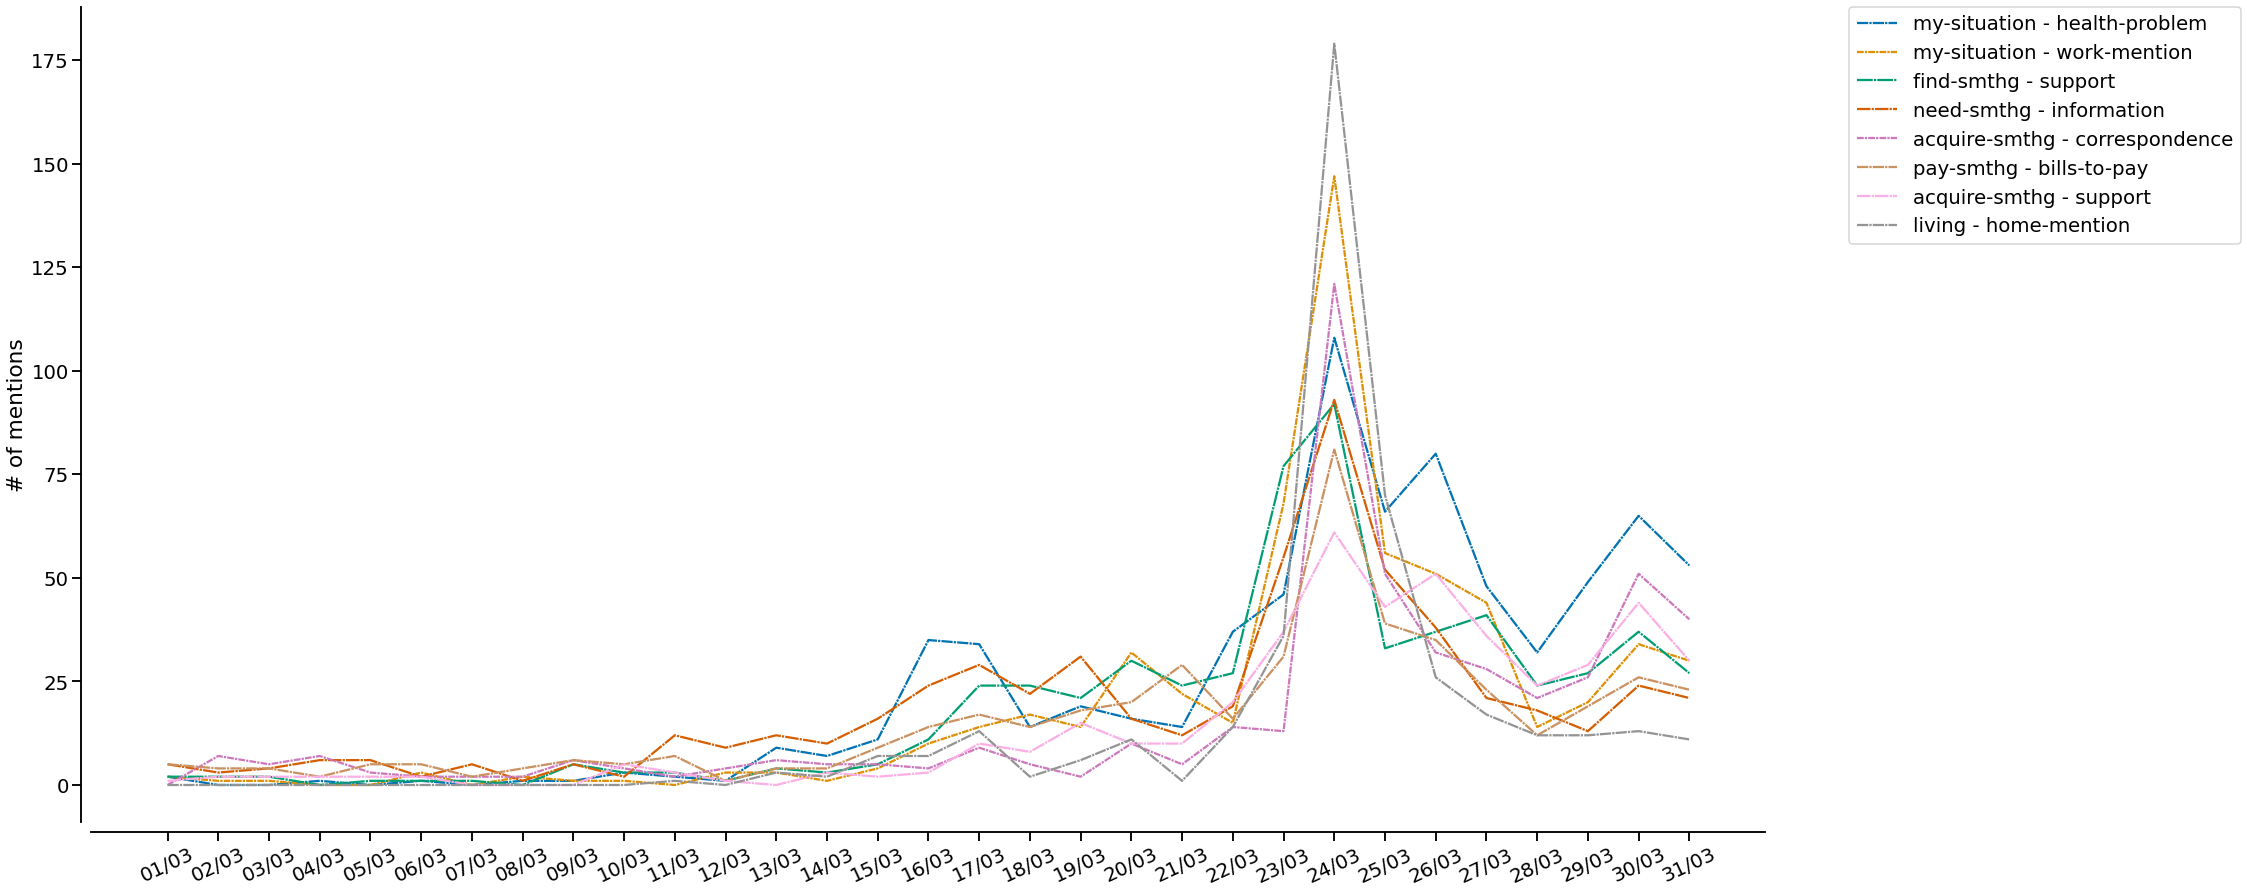

In [1827]:
sns.set_context("talk", font_scale=1.2)
plt.figure(figsize=(30, 15))

# ax = sns.lineplot(index, 375, color='black', alpha=0.5)
# ax.lines[0].set_linestyle("--")
# plt.axvline(20200324)

palette = sns.color_palette("colorblind", df2.shape[1])
ax = sns.lineplot(data=df2, palette=palette, dashes = generate_dash(df2.shape[1]))

plt.ylabel(r'# of mentions')
plt.xlabel('')

# plt.yticks(np.arange(0, maximum_value, step=50))

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), 
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

sns.despine(offset=10)

labels = [fix_index_label(ind.replace("2020", "")) for ind in index]
ax.set_xticklabels(labels, rotation=25)
plt.savefig(os.path.join(DATA_DIR, "exclude_info.png"), bbox_inches='tight')
plt.show()

## Fuzzy matching (not very helpful so far)

In [680]:
t1 = "can claim"
t2 = "to claim"
print(fuzz.partial_ratio(t1, t2))
print(fuzz.token_sort_ratio(t1, t2))

verb_associations = {}
for verb in tqdm_notebook(sorted(verbs,
                   key = lambda x: len(x.split(" ")))):
    excluded = verbs[:]
    excluded.remove(verb)
#     if verb == "can claim":
#         print(process.extractBests(verb, 
#                                    excluded, 
#                                    scorer=fuzz.token_sort_ratio))
    verb_associations[verb] = process.extractBests(verb, 
                                                   excluded, 
                                                   scorer=fuzz.token_sort_ratio, 
                                                   score_cutoff=80)
# verb_associations

75
59


/Users/felisialoukou/.virtualenvs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [688]:
merged = {}
skip = []
for k,v in sorted(verb_associations.items(),
                  key = lambda x: len(x[0])):
    if k not in skip:
        merged[k] = v[:]
        for vs in v:
            if vs[0] in verb_associations.keys():
                skip.append(vs[0])
                for vv in verb_associations[vs[0]]:
                    if vv[0] not in [val for val,_ in merged[k]] and vv[0] != k:
                        merged[k].append(vv)
                        skip.append(vv[0])

## if values intersect, merge
intersection = []
for k,v in merged.items():
    for m,n in merged.items():
        if k!=m:
            if len(set([phrase for phrase,_ in v]).intersection(set([phrase2 for phrase2,_ in n]))):
                print(f"{k}, {m}")
# merged

one, no phone
one, any money
ill, any bills
car, a car
info, forms
info, dla form
good, food
mail, an emal
food, good
late, text
late, better
late, 2 letters
sure, a surrey
text, late
able, vulnetable
able, just vulnerable
able, vulnerable family
able, elderly vulnerable
date, any updates
home, home now
home, a carehome
light, a fight
house, a hotel
alone, jason
alone, any money
funds, tax refund
funds, refunds back
forms, info
forms, dla form
jason, alone
jason, any money
a lot, no slots
a lot, any support
a car, car
school, school cleaners
retail, detsils
advice, disable
advice, the advice
advice, advice self
prison, pension
better, late
better, 2 letters
disable, advice
disable, disabled person
benefit, benefits easy
detsils, retail
detsils, more detail
pension, prison
process, the process
parents, 80 % payment
message, a txt msg
message, new messages
contact, zero hour contract
citizen, a uk citizen
a fight, light
an emal, mail
a hotel, house
shopping, online slot
shopping, online 

remote rural area, remote area
useful information, infomation
useful information, informative
useful information, confirmation
useful information, vital information
useful information, exact information
useful information, proper information
useful information, detailed information
useful information, no information apart
useful information, information the police
useful information, more information vulnerable
free prescriptions, restrict
free prescriptions, travel restrictions
vunerable category, elderly vulnerable
vunerable category, extremely vulnerable
vunerable category, under 70s vulnerable category
elderly vulnerable, able
elderly vulnerable, vulnetable
elderly vulnerable, just vulnerable
elderly vulnerable, vunerable group
elderly vulnerable, venerable people
elderly vulnerable, vulnerable status
elderly vulnerable, vulnerable family
elderly vulnerable, vunerable category
elderly vulnerable, medically vulnerable
elderly vulnerable, extremely vulnerable
elderly vulnerable, vune

In [ ]:
i = 1
rowlist = []
for key in [key for key in pattern_d.keys() ]:
#     print(key)
    for k,v in pattern_d[key].most_common():
        if "delivery" in k[1] or "deliver" in k[0]:
#             rowlist.append({f""})
            print(f"{i}. [{k[0]}] {k[1]} : {v}")
            i+=1
    print()
    i=1

## Compute triples

In [ ]:
pd_triples = compute_linguistic_patterns(df.pos_tag, 3)

for i, (k,v) in enumerate(sorted(pd_triples.items(), 
                                 key = lambda x: len(x[1]), 
                                 reverse=True), 
                          1):
    print(f"{i}. {' - '.join([ks.upper() for ks in k])} : {len(v)}\n-------------")
    for j, (args, counts) in enumerate(pd_triples[k].most_common(10), 1):
        print(f"{j}. {args}: {counts}")
    print()
    print("=======\n")